In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
POLG_scores_df = pd.read_csv("Supplementary_table_3_POLG_scores.csv")

In [6]:
def create_simple_pymol_script(polg_scores_df, output_filename='simple_polg.pml',
                              score_column='average_W748S_score_norm_syn', 
                              position_column='p_variant', pdb_id='8d33',
                              threshold=-1.489712):
    """
    Create a PyMOL script with the following features:
    - Chain A only (B and C hidden), limited to positions 785 and up
    - Chain A colored gray60 with transparency for sphere visibility
    - Only positions with scores below threshold show RED spheres at side chain (CB) positions
    - Sphere size scaled by number of variants below threshold (1.0 base + 0.3 per additional variant)
    - Proper rendering order: nucleic acid (opaque) → spheres → protein cartoon (transparent)
    - Extracts position from p_variant column (e.g., R866Q -> 866)
    """
    
    # Get clean data
    df_clean = polg_scores_df.dropna(subset=[score_column, position_column]).copy()
    
    if df_clean.empty:
        print("No valid data found!")
        return None
    
    # Extract numeric position from p_variant (e.g., R866Q -> 866)
    df_clean['real_pos'] = df_clean[position_column].str.extract(r'(\d+)').astype(int)
    
    # Find positions with scores below threshold
    below_threshold = df_clean[df_clean[score_column] < threshold]
    
    if below_threshold.empty:
        print(f"No positions found with scores below threshold {threshold}")
        return None
    
    # Count variants below threshold per position and get stats
    position_stats = below_threshold.groupby('real_pos').agg({
        score_column: ['count', 'mean', 'min']
    }).reset_index()
    
    # Flatten column names
    position_stats.columns = ['real_pos', 'variant_count', 'mean_score', 'min_score']
    
    print(f"Creating script for {len(position_stats)} positions with scores below {threshold}")
    print(f"Variant counts per position range from {position_stats['variant_count'].min()} to {position_stats['variant_count'].max()}")
    
    # Start building script
    script_lines = [
        f"# PyMOL script for POLG SGE scores - Chain A only (positions 785+)",
        f"# Threshold: {threshold}",
        f"# Positions below threshold: {len(position_stats)}",
        f"# Variant counts: {position_stats['variant_count'].min()}-{position_stats['variant_count'].max()}",
        "",
        f"# Load structure and basic setup",
        f"fetch {pdb_id}",
        f"hide everything, {pdb_id}",
        "",
        f"# Hide chains B and C, show only chain A positions 785 and up",
        f"hide everything, {pdb_id} and chain B",
        f"hide everything, {pdb_id} and chain C",
        f"show cartoon, {pdb_id} and chain A and resi 785-9999",
        "",
        f"# Set transparency mode first",
        f"set transparency_mode, 2",
        "",
        f"# Show nucleic acids first (no transparency)",
        f"show cartoon, {pdb_id} and polymer.nucleic",
        f"color slate, {pdb_id} and polymer.nucleic",
        f"set cartoon_transparency, 0.0, {pdb_id} and polymer.nucleic",
        "",
        f"# General settings", 
        f"bg_color white",
        ""
    ]
    
    # Add red spheres for positions below threshold
    for _, row in position_stats.iterrows():
        pos = int(row['real_pos'])
        variant_count = int(row['variant_count'])
        mean_score = row['mean_score']
        
        # Calculate sphere scale: 1.0 base + 0.3 per additional variant
        # So 1 variant = 1.0, 2 variants = 1.3, 3 variants = 1.6, etc.
        sphere_scale = 1.0 + (variant_count - 1) * 0.3
        
        script_lines.extend([
            f"# Position {pos}: {variant_count} variants below threshold (mean score = {mean_score:.3f})",
            f"show spheres, {pdb_id} and chain A and resi {pos} and name CB",
            f"color red, {pdb_id} and chain A and resi {pos} and name CB",
            f"set sphere_scale, {sphere_scale:.1f}, {pdb_id} and chain A and resi {pos} and name CB",
            f"set sphere_transparency, 0.0, {pdb_id} and chain A and resi {pos} and name CB",
            ""
        ])
    
    # Now set protein cartoon with transparency (after spheres are defined)
    script_lines.extend([
        f"# Set protein cartoon with transparency so spheres show through",
        f"color gray60, {pdb_id} and chain A and resi 785-9999",
        f"set cartoon_transparency, 0.3, {pdb_id} and chain A and resi 785-9999",
        ""
    ])
    
    # Rebuild to apply changes
    script_lines.extend([
        f"rebuild",
        ""
    ])
    
    # Final commands
    script_lines.extend([
        f"# Final orientation",
        f"orient {pdb_id} and chain A and resi 785-9999",
        f"zoom {pdb_id} and chain A and resi 785-9999",
        "",
        'print "Script completed successfully"',
        f'print "Chain A shown with gray60 coloring and transparency"',
        f'print "Chain A limited to positions 785 and up"',
        f'print "Only positions with scores < {threshold} show RED spheres"',
        f'print "Sphere sizes scaled by variant count (1.0 + 0.3 per additional variant)"',
        f'print "Nucleic acids shown opaque, protein cartoon transparent"',
        f'print "Chains B and C are hidden"',
        f'print "{len(position_stats)} positions with red spheres displayed"'
    ])
    
    # Write to file
    with open(output_filename, 'w') as f:
        f.write('\n'.join(script_lines))
    
    print(f"Updated script saved to: {output_filename}")
    print("Script features:")
    print(f"  - Chain A only (B and C hidden), positions 785 and up")
    print(f"  - Chain A: gray60, transparent for sphere visibility")
    print(f"  - Threshold: {threshold}")
    print(f"  - {len(position_stats)} positions with RED spheres (scores < threshold)")
    print(f"  - Sphere sizes: 1.0 base + 0.3 per additional variant")
    print(f"  - Proper rendering order: nucleic acid → spheres → protein cartoon")
    print(f"  - Variant count range: {position_stats['variant_count'].min()}-{position_stats['variant_count'].max()}")
    
    return output_filename

# Call with p_variant column (now default)
script_file = create_simple_pymol_script(POLG_scores_df, 'just_hand_W748S.pml')

Creating script for 13 positions with scores below -1.489712
Variant counts per position range from 1 to 5
Updated script saved to: just_hand_W748S.pml
Script features:
  - Chain A only (B and C hidden), positions 785 and up
  - Chain A: gray60, transparent for sphere visibility
  - Threshold: -1.489712
  - 13 positions with RED spheres (scores < threshold)
  - Sphere sizes: 1.0 base + 0.3 per additional variant
  - Proper rendering order: nucleic acid → spheres → protein cartoon
  - Variant count range: 1-5


In [18]:
colors = {
    "Nonsense": "#F3001C",
    "Pathogenic": "#b00707",
    "Canon_splice": "#d6621a",
    "intron": "#af79c9",
    "missense": "#00BA74",
    "missense_DN": "#0a4a1b",
    "Splice region": "#fdba00",
    "Synonymous": "#456CCC",
    "STOP_LOST": "#9D0012",
    "1": "#B5A695",
    "5PRIME_UTR": "#B5A695",
    "WT": "#000000",
    "0": "#BFBCBC",
    "Benign": "#3ec4ed",
    "Conflicting classifications of pathogenicity": "#8b8491",
    "Likely benign": "#6ec6f5",
    "Benign/Likely benign":"#6ec6f5", 
    "Likely pathogenic": "#A40000",
    "Pathogenic/Likely pathogenic": "#A40000",
    #"Pathogenic": "#A40000",
    "Uncertain significance": "#912b9e",
    "Library": "#dedede",
    "Path_missense": "#dc21fc",
    "Benign_missense": "#33f54a",
    "C10_missense": "#39915f",
    "VUS": "#854599",
    "count_input": "#515757"
}

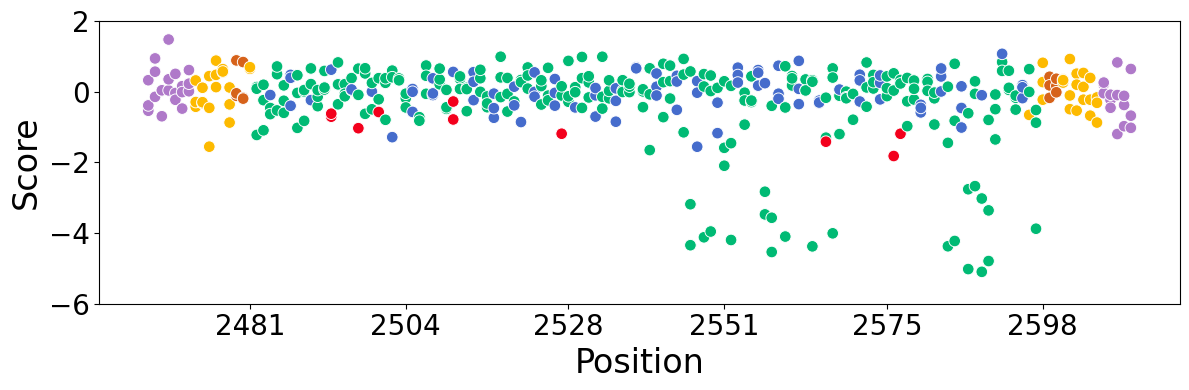

In [17]:
import re
import numpy as np

def parse_c_variant_position(c_var):
  
    c_var = str(c_var).replace('c.', '')
    
    # Check for intronic variants with - or +
    if '-' in c_var:
        match = re.match(r'(\d+)-(\d+)', c_var)
        if match:
            base_pos = int(match.group(1))
            offset = int(match.group(2))
            return base_pos - offset
    
    elif '+' in c_var:
        match = re.match(r'(\d+)\+(\d+)', c_var)
        if match:
            base_pos = int(match.group(1))
            offset = int(match.group(2))
            return base_pos + offset
    
    else:
        # Exonic variant - just the number
        match = re.match(r'(\d+)', c_var)
        if match:
            return int(match.group(1))
    
    return None

def get_base_position(c_var):
    """Get the base exon position without offset"""
    c_var = str(c_var).replace('c.', '')
    match = re.match(r'(\d+)', c_var)
    if match:
        return int(match.group(1))
    return None

# Create position column
POLG_scores_df['plot_position'] = POLG_scores_df['c_variant'].apply(parse_c_variant_position)
POLG_scores_df['base_position'] = POLG_scores_df['c_variant'].apply(get_base_position)

# Sort by position
POLG_scores_df = POLG_scores_df.sort_values('plot_position')

# Get min and max base positions
unique_bases = sorted(POLG_scores_df['base_position'].unique())
min_base = unique_bases[0]
max_base = unique_bases[-1]

# Create evenly spaced tick positions (round to nice numbers)
num_ticks = 6  # Adjust this for more/fewer ticks
tick_positions = np.linspace(min_base, max_base, num_ticks)
tick_positions = [int(round(pos)) for pos in tick_positions]

# Plot
plt.figure(figsize=(12, 4))
sns.scatterplot(data=POLG_scores_df, 
                x='plot_position', 
                y='average_W748S_score_norm_syn', 
                hue='consequence', 
                palette=colors, 
                legend=False,
                s=70)

plt.xlabel("Position", fontsize=24)
plt.ylabel("Score", fontsize=24)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-6, 2)

# Set x-axis ticks with truly even spacing
plt.xticks(tick_positions, tick_positions)

plt.tight_layout()
plt.savefig("POLG_exon_16_iPSC_W748S_dots_consequence.png", dpi=300)
plt.show()

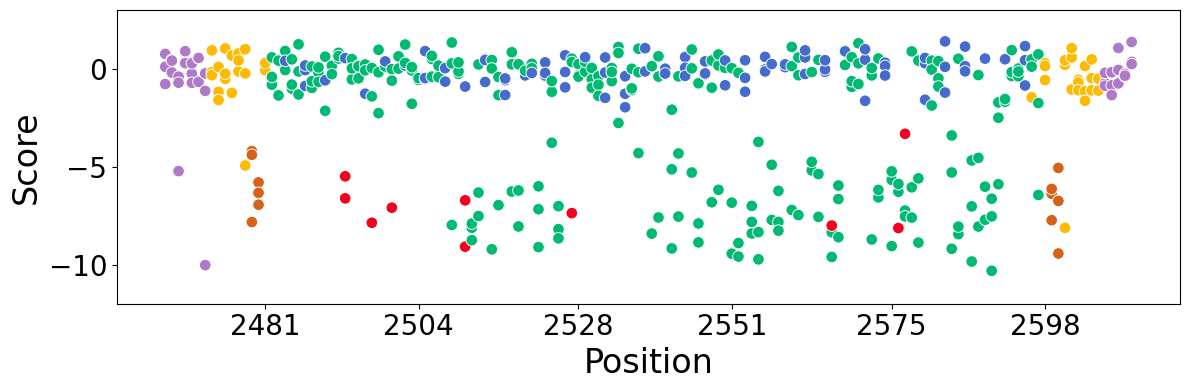

In [20]:
import re
import numpy as np

def parse_c_variant_position(c_var):
  
    c_var = str(c_var).replace('c.', '')
    
    # Check for intronic variants with - or +
    if '-' in c_var:
        match = re.match(r'(\d+)-(\d+)', c_var)
        if match:
            base_pos = int(match.group(1))
            offset = int(match.group(2))
            return base_pos - offset
    
    elif '+' in c_var:
        match = re.match(r'(\d+)\+(\d+)', c_var)
        if match:
            base_pos = int(match.group(1))
            offset = int(match.group(2))
            return base_pos + offset
    
    else:
        # Exonic variant - just the number
        match = re.match(r'(\d+)', c_var)
        if match:
            return int(match.group(1))
    
    return None

def get_base_position(c_var):
    """Get the base exon position without offset"""
    c_var = str(c_var).replace('c.', '')
    match = re.match(r'(\d+)', c_var)
    if match:
        return int(match.group(1))
    return None

# Create position column
POLG_scores_df['plot_position'] = POLG_scores_df['c_variant'].apply(parse_c_variant_position)
POLG_scores_df['base_position'] = POLG_scores_df['c_variant'].apply(get_base_position)

# Sort by position
POLG_scores_df = POLG_scores_df.sort_values('plot_position')

# Get min and max base positions
unique_bases = sorted(POLG_scores_df['base_position'].unique())
min_base = unique_bases[0]
max_base = unique_bases[-1]

# Create evenly spaced tick positions (round to nice numbers)
num_ticks = 6  # Adjust this for more/fewer ticks
tick_positions = np.linspace(min_base, max_base, num_ticks)
tick_positions = [int(round(pos)) for pos in tick_positions]

# Plot
plt.figure(figsize=(12, 4))
sns.scatterplot(data=POLG_scores_df, 
                x='plot_position', 
                y='average_null_score_norm_syn', 
                hue='consequence', 
                palette=colors, 
                legend=False,
                s=70)

plt.xlabel("Position", fontsize=24)
plt.ylabel("Score", fontsize=24)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.ylim(-12, 3)

# Set x-axis ticks with truly even spacing
plt.xticks(tick_positions, tick_positions)

plt.tight_layout()
plt.savefig("POLG_exon_16_iPSC_null_dots_consequence.png", dpi=300)
plt.show()